In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
# from tqdm import tqdm_notebook,trange
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

In [2]:
store_path_base = r"/raid6/roozbeh/trip_similarity/"
data_path_base = r"../data/"
morning_df_parquet_name = r"koln_morning_dataframe.parquet"

In [3]:
if not os.path.isfile(os.path.join(data_path_base, morning_df_parquet_name)):
    store = pd.HDFStore(os.path.join(store_path_base,"kolntr.h5"))
    df = store['kolndf']
    store.close()
    halfday = df[df.time < 13 * 3600]
    morningdf = halfday.groupby('trip_id').apply(lambda tripdf : tripdf if (len(tripdf) >= 50) and (tripdf.time.min() > 6 * 3600 - 30) and (tripdf.time.max() < 10 * 3600 + 30) else None)
    morningdf_no_nan = morningdf[~morningdf.isna().any(axis=1)]
    print(morningdf.trip_id.value_counts(dropna=False))
    print(morningdf_no_nan.trip_id.value_counts(dropna=False))
    print("len(morningdf): {}, len(morningdf_no_nan): {}",len(morningdf),len(morningdf_no_nan))
    morningdf_no_nan.to_parquet('koln_morning_dataframe.parquet')
else:
    print("Morningdf parquet file found. Proceeding.")

Morningdf parquet file found. Proceeding.


In [4]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, morning_df_parquet_name))

In [5]:
morningdf_no_nan

,time,trip_id,x,y,spd
8484331,21571.0,1401792,22056.400000,17311.490000,0.00
8484575,21571.0,336633,13315.950000,12687.650000,0.00
8484627,21571.0,634311,17555.460000,16582.760000,0.00
8485512,21571.0,1104353,20378.930000,20609.890000,0.00
8485641,21571.0,23620,22693.530000,6839.980000,0.00
...,...,...,...,...,...
115788320,36029.0,1159596,20881.964570,8171.417369,22.02
115788351,36029.0,169979,13888.929325,24502.642987,3.65
115788850,36029.0,1208490,15614.362823,12468.408416,4.56
115788966,36029.0,1534301,11829.848768,13325.926609,13.22


In [6]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [7]:
def min_max_scaler(series,min_,max_):
    return (series - min_)/(max_ - min_)

In [8]:
morningdf_no_nan.x = min_max_scaler(morningdf_no_nan.x, xmin, xmax)
morningdf_no_nan.y = min_max_scaler(morningdf_no_nan.y, ymin, ymax)

In [12]:
# morningdf_no_nan.sort_values(['trip_id','time'])

In [13]:
def get_trips_50_points(tripdf):
    if len(tripdf) < 50:
        return
    
    tripdf = tripdf.sort_values(by='time').reset_index(drop=True)
    first_48_last = [tripdf.iloc[[0]], tripdf[1:-1].sample(n=48).sort_values(by='time'), tripdf.iloc[[-1]]]
    tripdf = pd.concat(first_48_last,axis=0).reset_index(drop=True)
    return tripdf.drop('trip_id',axis=1)
    

In [14]:
tempdf = morningdf_no_nan.groupby('trip_id').apply(get_trips_50_points)


In [15]:
tempdf

time         x         y    spd
trip_id                                       
1000007 0   26798.0  0.684278  0.570806   0.00
        1   26804.0  0.685274  0.571578   9.74
        2   26824.0  0.694287  0.576280  11.37
        3   26832.0  0.694457  0.573746  13.45
        4   26841.0  0.690615  0.570789  13.36
...             ...       ...       ...    ...
769414  45  28013.0  0.478249  0.422410   0.00
        46  28034.0  0.470983  0.421721  13.19
        47  28041.0  0.467166  0.421616  13.08
        48  28085.0  0.445628  0.418934   0.53
        49  28199.0  0.428012  0.418688  15.73

[8731150 rows x 4 columns]

In [16]:
tempdf = tempdf.reset_index(level=1)

In [17]:
tempdf.rename({'level_1' : 'point_index'},inplace=True,axis=1)

In [18]:
tempdf

,point_index,time,x,y,spd
trip_id,,,,,
1000007,0,26798.0,0.684278,0.570806,0.00
1000007,1,26804.0,0.685274,0.571578,9.74
1000007,2,26824.0,0.694287,0.576280,11.37
1000007,3,26832.0,0.694457,0.573746,13.45
1000007,4,26841.0,0.690615,0.570789,13.36
...,...,...,...,...,...
769414,45,28013.0,0.478249,0.422410,0.00
769414,46,28034.0,0.470983,0.421721,13.19
769414,47,28041.0,0.467166,0.421616,13.08


In [19]:
# tempdf['tupled'] = tempdf.apply(lambda x: (x.time,x.x,x.y,x.spd),axis=1)

In [20]:
times_matrix = tempdf.pivot_table(index='trip_id',values='time',columns='point_index',aggfunc=lambda x: x)
x_matrix = tempdf.pivot_table(index='trip_id',values='x',columns='point_index',aggfunc=lambda x: x)
y_matrix = tempdf.pivot_table(index='trip_id',values='y',columns='point_index',aggfunc=lambda x: x)
spd_matrix = tempdf.pivot_table(index='trip_id',values='spd',columns='point_index',aggfunc=lambda x: x)

In [21]:
times_matrix.columns =[str(i) for i in range(50)]
x_matrix.columns = [str(i) for i in range(50)]
y_matrix.columns = [str(i) for i in range(50)]
spd_matrix.columns = [str(i) for i in range(50)]

In [22]:
times_matrix.to_parquet(os.path.join(data_path_base, 'morning_times_matrix.parquet'))
x_matrix.to_parquet(os.path.join(data_path_base, 'morning_x_matrix.parquet'))
y_matrix.to_parquet(os.path.join(data_path_base, 'morning_y_matrix.parquet'))
spd_matrix.to_parquet(os.path.join(data_path_base, 'morning_spd_matrix.parquet'))

In [24]:
tempdf.to_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

In [9]:
tempdf = pd.read_parquet(os.path.join(data_path_base, 'morning_trips_df_with_50points.parquet'))

## CHECKPOINT
The matrices created represent time, x, y, and speed at corresponding point (column) of the trip (row)

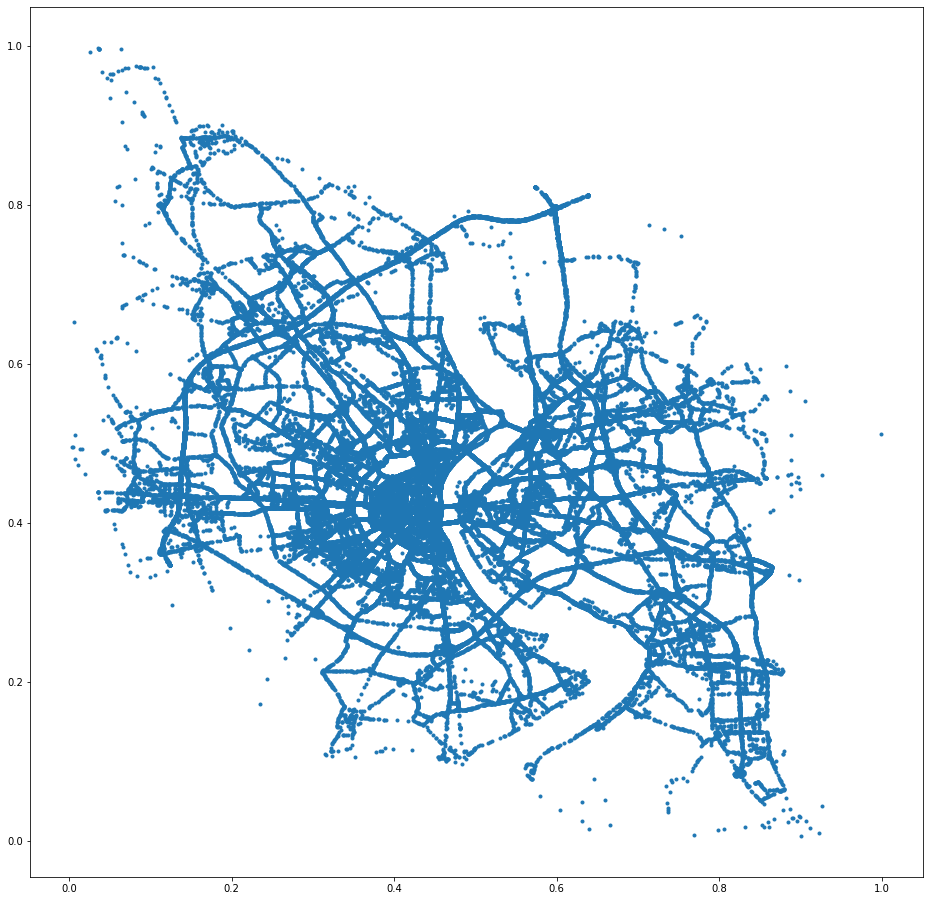

In [152]:
plt.figure(figsize=(16,16))
sampledf = tempdf.sample(100000)
plt.scatter(x = sampledf.x,y=sampledf.y, marker='.')

In [6]:
spatial_step = 50

time_threshold = 60 * 30 #seconds since data is per second

------

#### Defining distance/similarity

In [10]:
w_x = 0.5
w_t = 1-w_x
#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
def get_trip_similarity_wgm(t1,t2):
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[5] - t2[5]) ** 2 + (t1[6] - t2[6])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[4]-t2[4])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

##### Let's try getting an affinity matrix

In [11]:
def get_OD_from_50(tripdf):
    return pd.DataFrame([[tripdf.iloc[0,1], tripdf.iloc[0,2], tripdf.iloc[0,3], tripdf.iloc[0,4],
     tripdf.iloc[1,1], tripdf.iloc[1,2], tripdf.iloc[1,3], tripdf.iloc[1,4]]])
    
    

In [14]:
ODdf = tempdf[:1000000].groupby('trip_id').apply(get_OD_from_50)
ODdf.columns=['orig_time','orig_x','orig_y','orig_spd','dest_time','dest_x','dest_y','dest_spd']

In [15]:
ODdf.reset_index(level=1,drop=True,inplace=True)

In [16]:
ODdf

,orig_time,orig_x,orig_y,orig_spd,dest_time,dest_x,dest_y,dest_spd
trip_id,,,,,,,,
1000007,26798.0,0.684278,0.570806,0.0,26804.0,0.685274,0.571578,9.74
1000011,23414.0,0.505815,0.250499,0.0,23417.0,0.505366,0.250347,6.08
1000015,23689.0,0.554151,0.161940,0.0,23734.0,0.554292,0.161518,10.15
1000020,26928.0,0.389398,0.389645,0.0,26935.0,0.390773,0.390996,13.07
1000024,25380.0,0.420249,0.567624,0.0,25396.0,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
1082904,29763.0,0.238727,0.735628,0.0,29767.0,0.238930,0.734998,7.98
1082910,27754.0,0.448070,0.468704,0.0,27779.0,0.447465,0.460888,5.64
1082917,25231.0,0.415090,0.390769,0.0,25240.0,0.413679,0.391347,0.22


In [24]:
sampleODdf = ODdf.sample(frac=0.2)

In [ ]:
sim_matrix = pairwise_distances(sampleODdf,metric=get_trip_similarity_wgm,n_jobs=128)

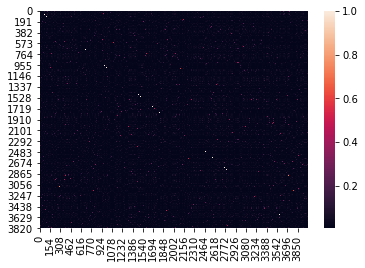

In [26]:
sns.heatmap(sim_matrix)

-----

##### Ploting parameters

In [17]:
cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [62]:
matplotlib.rcParams.update({'font.size': 20,'xtick.labelsize':30,'ytick.labelsize':30})

-------

#### This section is about generating sim or dissim (distances) for all the trips (no down sample). Analysis is done on samples below.

In [68]:
# distances8_wgm_v2 = pairwise_distances(ODdf_scaled,metric=get_trip_dissimilarity_from_tuple_scaled_wgm,n_jobs=-1)
# np.save("distances8_wgm_v2",distances8_wgm_v2)
# distances8_wgm_v2 = np.load("distances8_wgm_v2.npy")
# distances12_wgm_v2 = pairwise_distances(OD12df_scaled,metric=get_trip_dissimilarity_from_tuple_scaled_wgm,n_jobs=-1)
# np.save("distances12_wgm_v2",distances12_wgm_v2)
# distances20_wgm_v2 = pairwise_distances(OD20df_scaled,metric=get_trip_dissimilarity_from_tuple_scaled_wgm,n_jobs=-1)
# np.save("distances20_wgm_v2",distances20_wgm_v2)
# distances16_wgm_v2 = pairwise_distances(OD16df_scaled,metric=get_trip_dissimilarity_from_tuple_scaled_wgm,n_jobs=-1)
# np.save("distances16_wgm_v2",distances16_wgm_v2)

If complete matrices are needed load them from disk with np.load()

-----------

### Get a sample of size 2000 for 8am

In [19]:
sample8scaled = OD8df_scaled.sample(n=2000,random_state=54321)
sample8 = OD8df.sample(n=2000,random_state=54321)

In [20]:
similarities8 = pairwise_distances(sample8scaled,metric=get_trip_similarity_from_tuple_scaled_wgm,n_jobs=-1)

In [21]:
distances8 = 1 - similarities8

In [22]:
similarities8_gkern = np.exp(-4 * distances8  )

/home/roozbeh/miniconda3/envs/trip_similarity/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


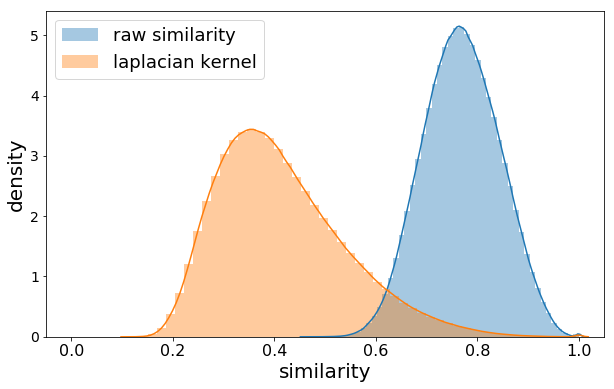

In [23]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities8,-1),norm_hist=True,label="raw similarity")
ax =  sns.distplot(np.reshape(similarities8_gkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.legend(prop= {"size" : 18})
plt.show()

-----

In [24]:
dbs_obj = DBSCAN(metric="precomputed",n_jobs=-1,min_samples=3,eps=0.075)

In [25]:
mds_obj = MDS(n_jobs=-1,dissimilarity='precomputed')

In [26]:
spc_obj = SpectralClustering(affinity='precomputed',n_jobs=-1,assign_labels="kmeans",random_state=54321)

In [27]:
pca_obj = PCA(n_components=2)

----

In [28]:
xyt_columns = ['time_begin','x_begin','y_begin','time_end','x_end','y_end']

#### 8am

In [29]:
pca_obj.fit(OD8df_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [30]:
pca_obj.explained_variance_ratio_

array([0.62049667, 0.2061206 ])

In [31]:
dbs_obj.fit(distances8)

DBSCAN(algorithm='auto', eps=0.075, leaf_size=30, metric='precomputed',
    metric_params=None, min_samples=3, n_jobs=-1, p=None)

In [32]:
Counter(dbs_obj.labels_)

Counter({0: 1785,
         -1: 98,
         1: 7,
         2: 5,
         3: 49,
         4: 25,
         5: 15,
         7: 4,
         8: 5,
         6: 4,
         9: 3})

In [33]:
mds_obj.fit(distances8)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-1, random_state=None, verbose=0)

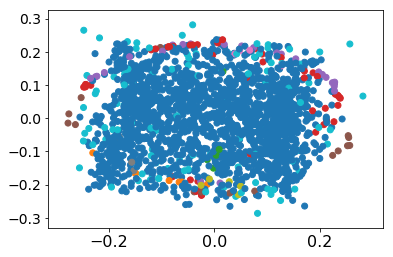

In [64]:
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in dbs_obj.labels_])
plt.show()

In [34]:
spc_obj.fit(similarities8)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [35]:
Counter(spc_obj.labels_)

Counter({4: 197, 7: 185, 6: 338, 1: 231, 3: 324, 0: 298, 2: 293, 5: 134})

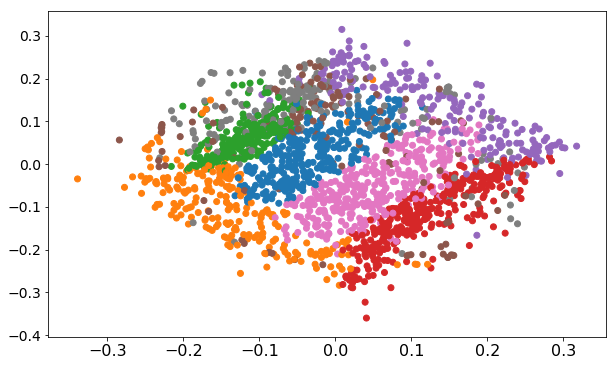

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [38]:
spc_obj.fit(similarities8_gkern)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [39]:
Counter(spc_obj.labels_)

Counter({0: 227, 6: 220, 3: 319, 1: 235, 4: 283, 2: 264, 7: 199, 5: 253})

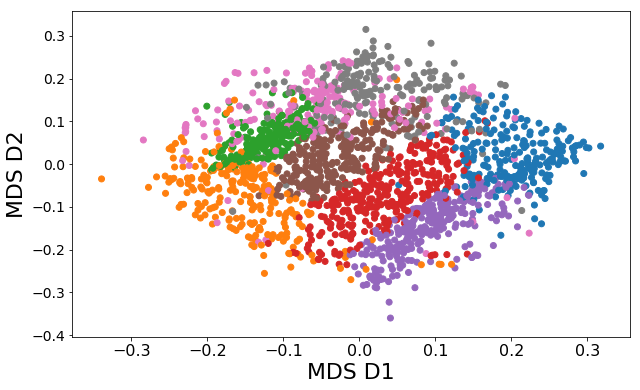

In [41]:
plt.figure(figsize=(10,6))

plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
ax = plt.gca()
ax.set_xlabel("MDS D1",fontsize=22)
ax.set_ylabel("MDS D2",fontsize=22)
plt.show()

In [42]:
pca_projection = pca_obj.transform(sample8scaled)

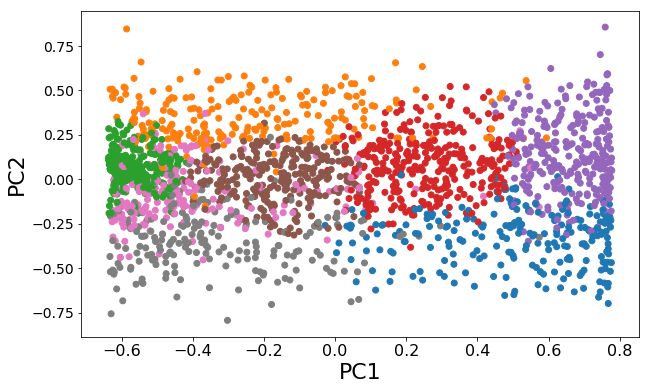

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1],c=[cyc_colors[lbl] for lbl in spc_obj.labels_])
ax = plt.gca()
ax.set_xlabel("PC1",fontsize=22)
ax.set_ylabel("PC2",fontsize=22)
plt.show()

Plot every point?

In [73]:
pca_projection_all = pca_obj.transform(OD8df_scaled)

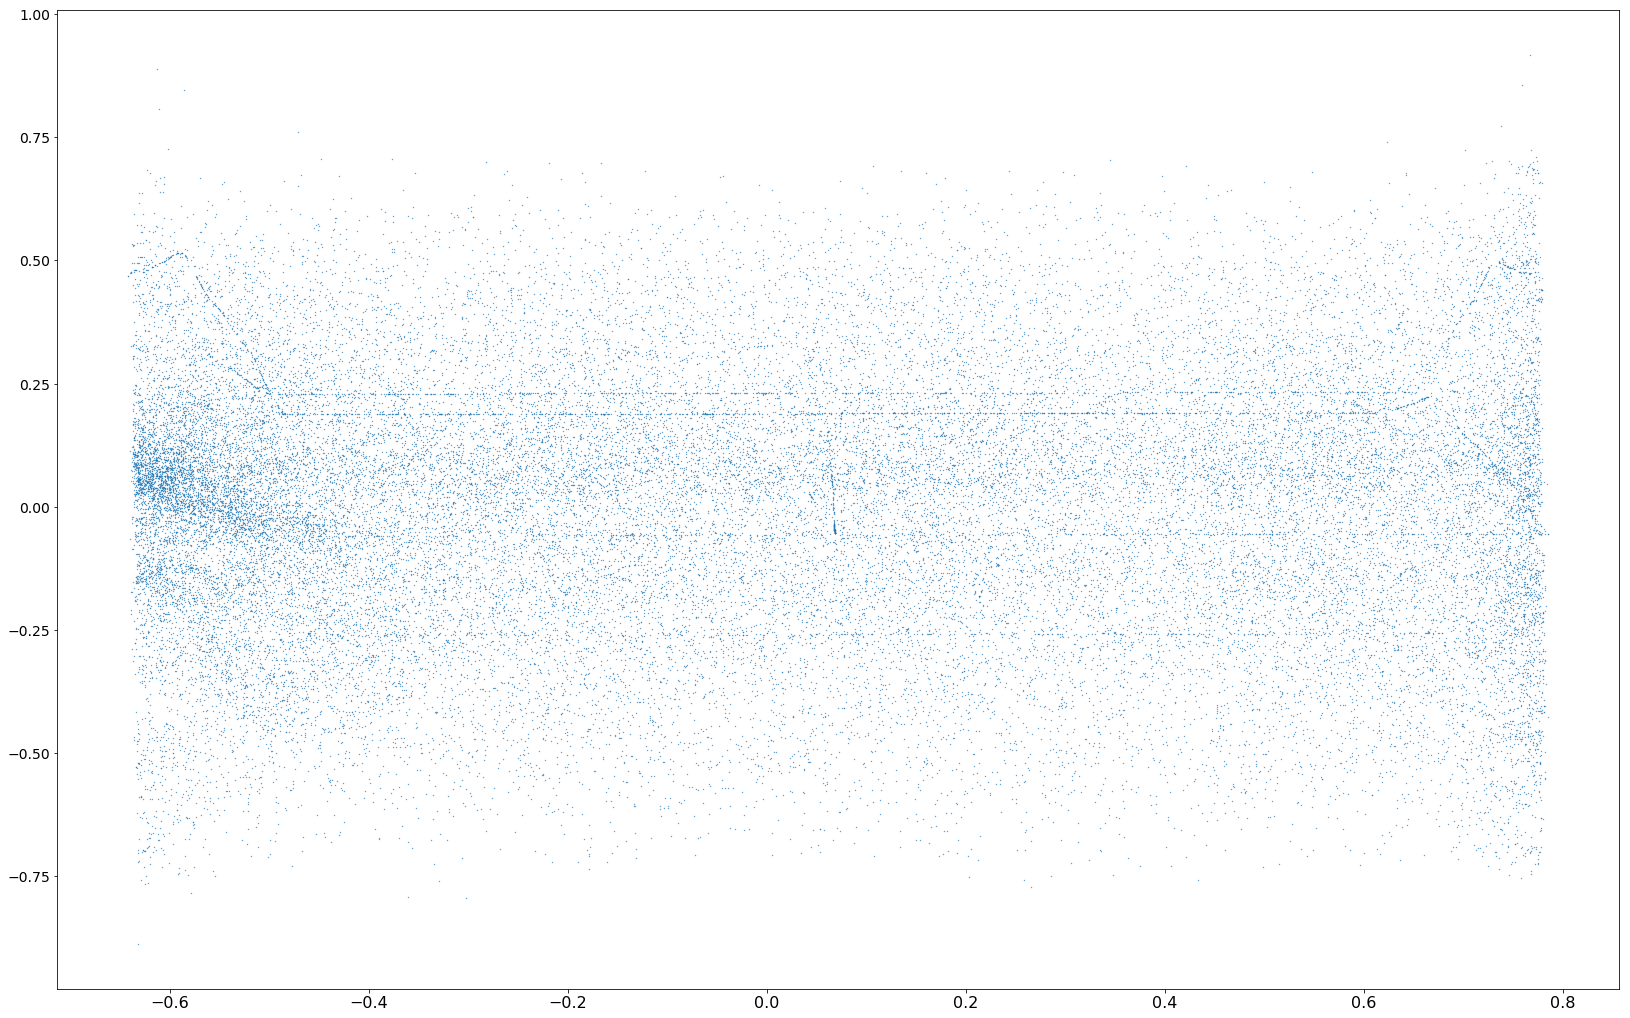

In [74]:
plt.figure(figsize=(28,18))
plt.scatter(pca_projection_all[:,0],pca_projection_all[:,1],s=0.1)
plt.show()

------

#### 12pm

In [210]:
np.random.seed(54321)
sample12index = np.random.choice(OD12df_scaled.index.values, 2000)

In [212]:
sample12scaled = OD12df_scaled.loc[sample12index,:]

In [215]:
similarities12 = pairwise_distances(sample12scaled,metric=get_trip_similarity_from_tuple_scaled_wgm,n_jobs=-1)

In [216]:
distances12 = 1 - similarities12

In [217]:
similarities12_gkern = np.exp(-0.3 * distances12 / distances12.std() )

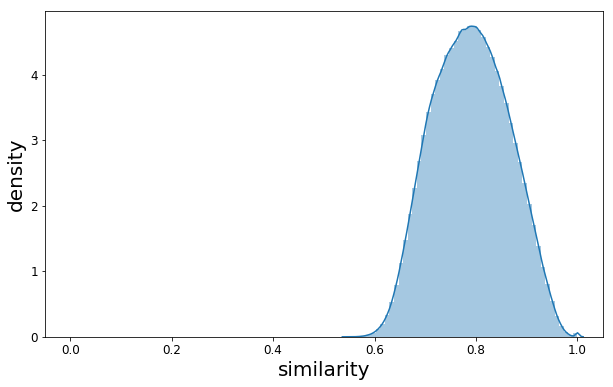

In [218]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities12,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

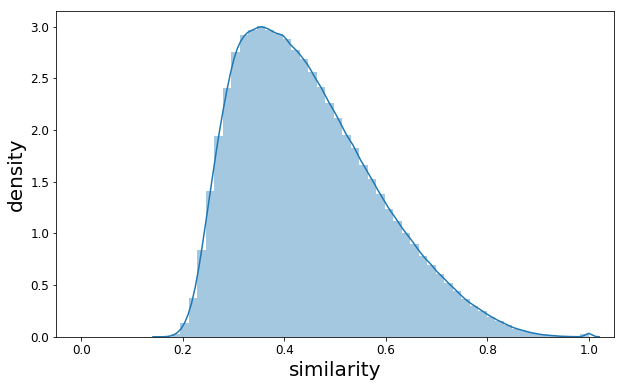

In [219]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities12_gkern,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

In [214]:
pca_obj.fit(OD12df_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [220]:
mds_obj.fit(distances12)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-1, random_state=None, verbose=0)

In [221]:
spc_obj.fit(similarities12)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [222]:
Counter(spc_obj.labels_)

Counter({0: 344, 1: 278, 2: 305, 3: 243, 4: 266, 5: 177, 6: 183, 7: 204})

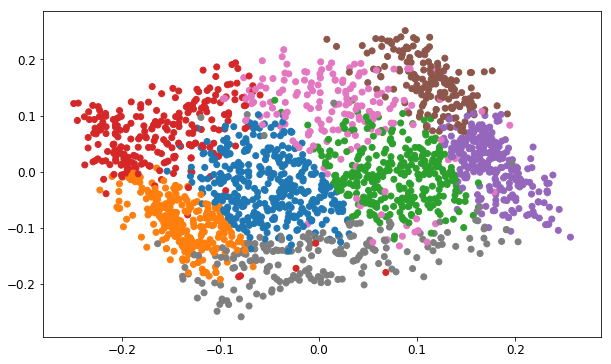

In [223]:
plt.figure(figsize=(10,6))
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [224]:
spc_obj.fit(similarities12_gkern)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [225]:
Counter(spc_obj.labels_)

Counter({0: 255, 1: 331, 2: 143, 3: 252, 4: 169, 5: 276, 6: 234, 7: 340})

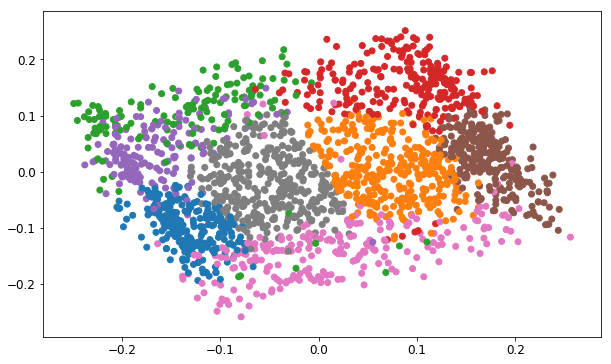

In [226]:
plt.figure(figsize=(10,6))

plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [227]:
pca_projection = pca_obj.transform(sample12scaled)

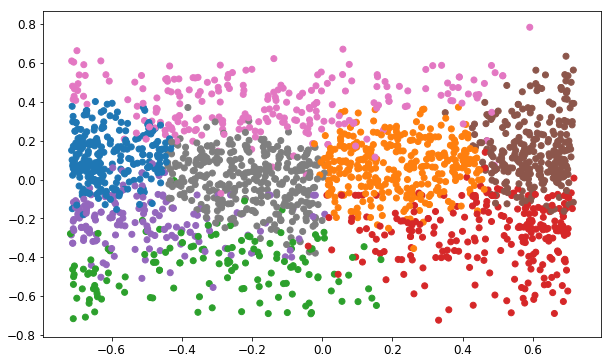

In [228]:
plt.figure(figsize=(10,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1],c=[cyc_colors[lbl] for lbl in spc_obj.labels_])
plt.show()

-----

### 4pm

In [229]:
np.random.seed(54321)
sample16index = np.random.choice(OD16df_scaled.index.values, 2000)

In [230]:
sample16scaled = OD16df_scaled.loc[sample16index,:]

In [231]:
similarities16 = pairwise_distances(sample16scaled,metric=get_trip_similarity_from_tuple_scaled_wgm,n_jobs=-1)

In [232]:
distances16 = 1 - similarities16

In [233]:
similarities16_gkern = np.exp(-0.3 * distances16 / distances16.std() )

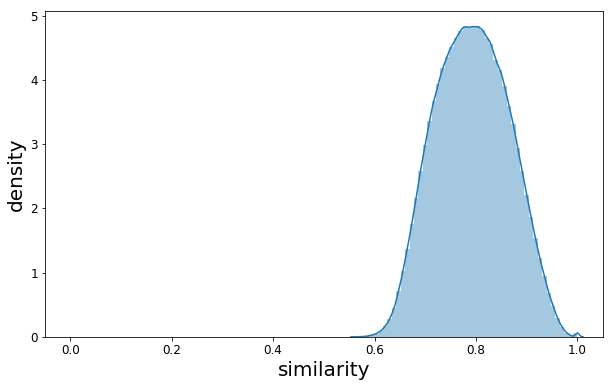

In [234]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities16,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

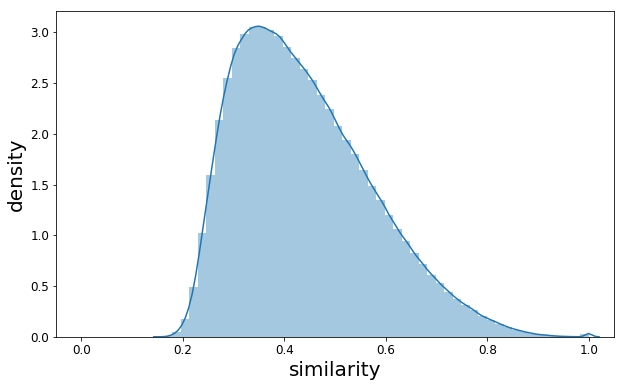

In [235]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities16_gkern,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

In [236]:
pca_obj.fit(OD16df_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [237]:
mds_obj.fit(distances16)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-1, random_state=None, verbose=0)

In [238]:
spc_obj.fit(similarities16)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [239]:
Counter(spc_obj.labels_)

Counter({0: 240, 1: 226, 2: 251, 3: 336, 4: 195, 5: 260, 6: 328, 7: 164})

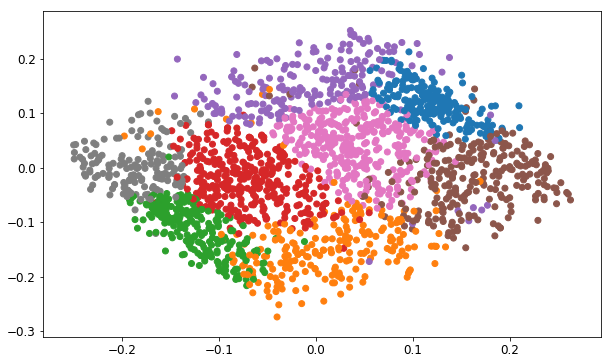

In [240]:
plt.figure(figsize=(10,6))
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [241]:
spc_obj.fit(similarities16_gkern)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [242]:
Counter(spc_obj.labels_)

Counter({0: 237, 1: 322, 2: 261, 3: 174, 4: 288, 5: 228, 6: 262, 7: 228})

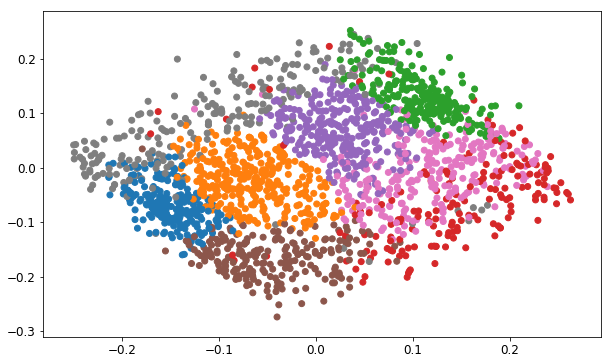

In [243]:
plt.figure(figsize=(10,6))

plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [244]:
pca_projection = pca_obj.transform(sample16scaled)

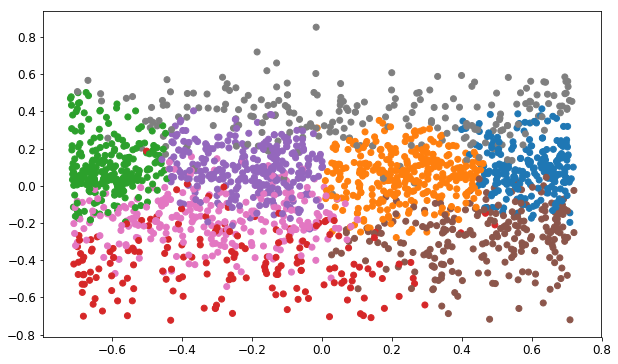

In [245]:
plt.figure(figsize=(10,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1],c=[cyc_colors[lbl] for lbl in spc_obj.labels_])
plt.show()

-----

### 8pm

In [246]:
np.random.seed(54321)
sample20index = np.random.choice(OD20df_scaled.index.values, 2000)

In [247]:
sample20scaled = OD20df_scaled.loc[sample20index,:]

In [248]:
similarities20 = pairwise_distances(sample20scaled,metric=get_trip_similarity_from_tuple_scaled_wgm,n_jobs=-1)

In [249]:
distances20 = 1 - similarities20

In [250]:
similarities20_gkern = np.exp(-0.3 * distances20 / distances20.std() )

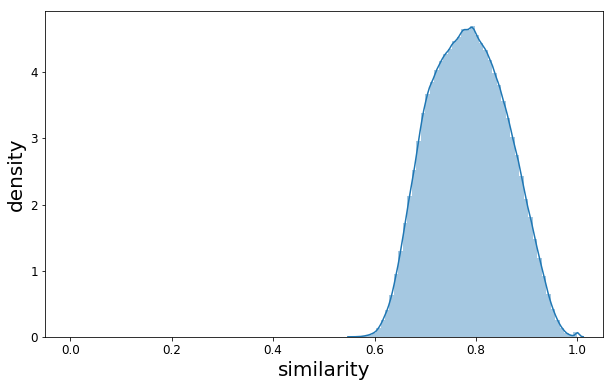

In [251]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities20,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

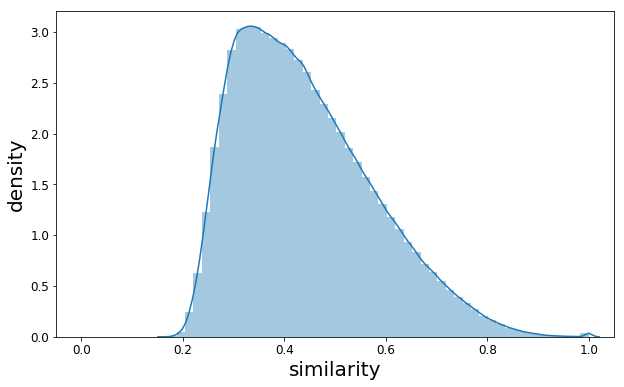

In [252]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities20_gkern,-1),norm_hist=True)
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.show()

In [253]:
pca_obj.fit(OD20df_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [254]:
mds_obj.fit(distances20)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-1, random_state=None, verbose=0)

In [255]:
spc_obj.fit(similarities20)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [256]:
Counter(spc_obj.labels_)

Counter({0: 181, 1: 270, 2: 188, 3: 270, 4: 299, 5: 254, 6: 191, 7: 347})

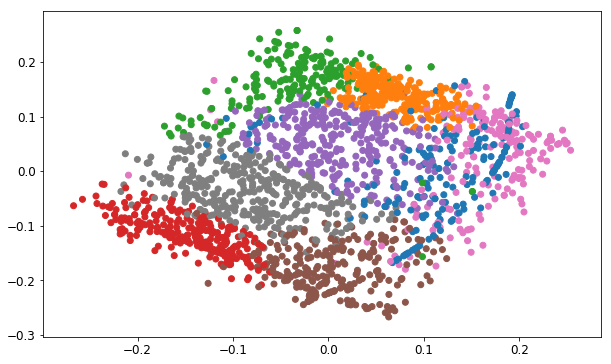

In [257]:
plt.figure(figsize=(10,6))
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [258]:
spc_obj.fit(similarities20_gkern)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [259]:
Counter(spc_obj.labels_)

Counter({0: 187, 1: 333, 2: 187, 3: 274, 4: 279, 5: 275, 6: 267, 7: 198})

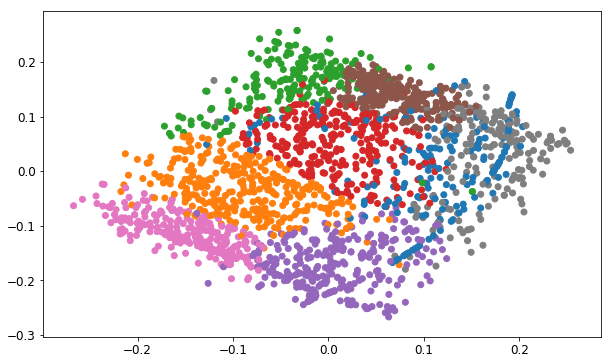

In [260]:
plt.figure(figsize=(10,6))

plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [261]:
pca_projection = pca_obj.transform(sample20scaled)

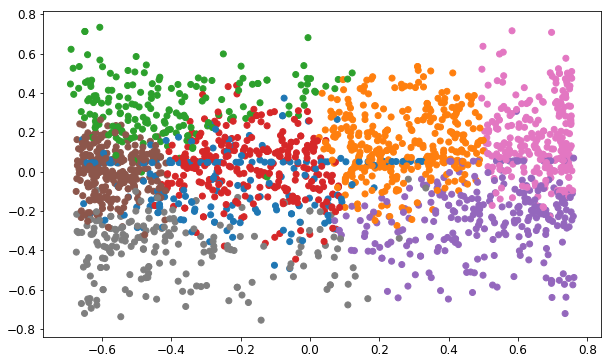

In [262]:
plt.figure(figsize=(10,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1],c=[cyc_colors[lbl] for lbl in spc_obj.labels_])
plt.show()

In [44]:
cluster0 = sample8scaled[spc_obj.labels_ == 0]
cluster1 = sample8scaled[spc_obj.labels_ == 1]
cluster2 = sample8scaled[spc_obj.labels_ == 2]
cluster3 = sample8scaled[spc_obj.labels_ == 3]
cluster4 = sample8scaled[spc_obj.labels_ == 4]
cluster5 = sample8scaled[spc_obj.labels_ == 5]
cluster6 = sample8scaled[spc_obj.labels_ == 6]
cluster7 = sample8scaled[spc_obj.labels_ == 7]

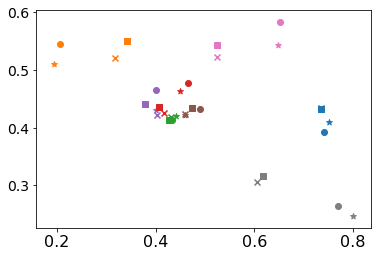

In [45]:
plt.scatter(np.mean(cluster0.x_begin),np.mean(cluster0.y_begin),c=cyc_colors[0])
plt.scatter(np.mean(cluster1.x_begin),np.mean(cluster1.y_begin),c=cyc_colors[1])
plt.scatter(np.mean(cluster2.x_begin),np.mean(cluster2.y_begin),c=cyc_colors[2])
plt.scatter(np.mean(cluster3.x_begin),np.mean(cluster3.y_begin),c=cyc_colors[3])
plt.scatter(np.mean(cluster4.x_begin),np.mean(cluster4.y_begin),c=cyc_colors[4])
plt.scatter(np.mean(cluster5.x_begin),np.mean(cluster5.y_begin),c=cyc_colors[5])
plt.scatter(np.mean(cluster6.x_begin),np.mean(cluster6.y_begin),c=cyc_colors[6])
plt.scatter(np.mean(cluster7.x_begin),np.mean(cluster7.y_begin),c=cyc_colors[7])

plt.scatter(np.median(cluster0.x_begin),np.median(cluster0.y_begin),c=cyc_colors[0],marker='*')
plt.scatter(np.median(cluster1.x_begin),np.median(cluster1.y_begin),c=cyc_colors[1],marker='*')
plt.scatter(np.median(cluster2.x_begin),np.median(cluster2.y_begin),c=cyc_colors[2],marker='*')
plt.scatter(np.median(cluster3.x_begin),np.median(cluster3.y_begin),c=cyc_colors[3],marker='*')
plt.scatter(np.median(cluster4.x_begin),np.median(cluster4.y_begin),c=cyc_colors[4],marker='*')
plt.scatter(np.median(cluster5.x_begin),np.median(cluster5.y_begin),c=cyc_colors[5],marker='*')
plt.scatter(np.median(cluster6.x_begin),np.median(cluster6.y_begin),c=cyc_colors[6],marker='*')
plt.scatter(np.median(cluster7.x_begin),np.median(cluster7.y_begin),c=cyc_colors[7],marker='*')


plt.scatter(np.mean(cluster0.x_end),np.mean(cluster0.y_end),c=cyc_colors[0],marker="s")
plt.scatter(np.mean(cluster1.x_end),np.mean(cluster1.y_end),c=cyc_colors[1],marker="s")
plt.scatter(np.mean(cluster2.x_end),np.mean(cluster2.y_end),c=cyc_colors[2],marker="s")
plt.scatter(np.mean(cluster3.x_end),np.mean(cluster3.y_end),c=cyc_colors[3],marker="s")
plt.scatter(np.mean(cluster4.x_end),np.mean(cluster4.y_end),c=cyc_colors[4],marker="s")
plt.scatter(np.mean(cluster5.x_end),np.mean(cluster5.y_end),c=cyc_colors[5],marker="s")
plt.scatter(np.mean(cluster6.x_end),np.mean(cluster6.y_end),c=cyc_colors[6],marker="s")
plt.scatter(np.mean(cluster7.x_end),np.mean(cluster7.y_end),c=cyc_colors[7],marker="s")

plt.scatter(np.median(cluster0.x_end),np.median(cluster0.y_end),c=cyc_colors[0],marker='x')
plt.scatter(np.median(cluster1.x_end),np.median(cluster1.y_end),c=cyc_colors[1],marker='x')
plt.scatter(np.median(cluster2.x_end),np.median(cluster2.y_end),c=cyc_colors[2],marker='x')
plt.scatter(np.median(cluster3.x_end),np.median(cluster3.y_end),c=cyc_colors[3],marker='x')
plt.scatter(np.median(cluster4.x_end),np.median(cluster4.y_end),c=cyc_colors[4],marker='x')
plt.scatter(np.median(cluster5.x_end),np.median(cluster5.y_end),c=cyc_colors[5],marker='x')
plt.scatter(np.median(cluster6.x_end),np.median(cluster6.y_end),c=cyc_colors[6],marker='x')
plt.scatter(np.median(cluster7.x_end),np.median(cluster7.y_end),c=cyc_colors[7],marker='x')

In [46]:
plt.show()

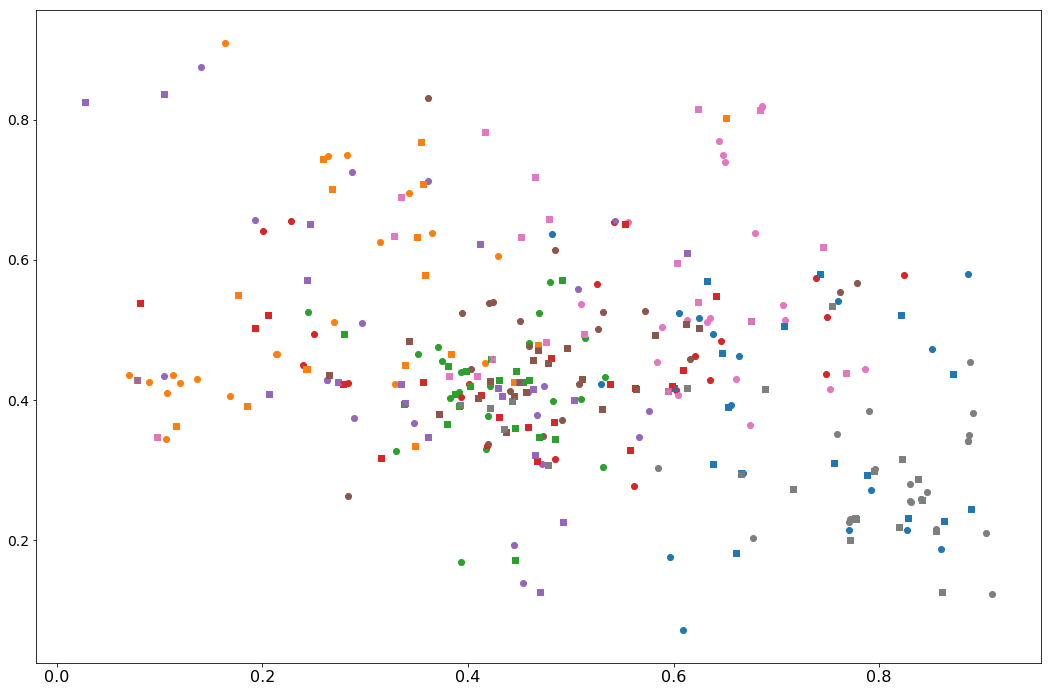

In [47]:
plt.figure(figsize=(18,12))

cluster0sample = cluster0.sample(n=20)
cluster1sample = cluster1.sample(n=20)
cluster2sample = cluster2.sample(n=20)
cluster3sample = cluster3.sample(n=20)
cluster4sample = cluster4.sample(n=20)
cluster5sample = cluster5.sample(n=20)
cluster6sample = cluster6.sample(n=20)
cluster7sample = cluster7.sample(n=20)

plt.scatter(cluster0sample.x_begin,cluster0sample.y_begin,c=cyc_colors[0])
plt.scatter(cluster1sample.x_begin,cluster1sample.y_begin,c=cyc_colors[1])
plt.scatter(cluster2sample.x_begin,cluster2sample.y_begin,c=cyc_colors[2])
plt.scatter(cluster3sample.x_begin,cluster3sample.y_begin,c=cyc_colors[3])
plt.scatter(cluster4sample.x_begin,cluster4sample.y_begin,c=cyc_colors[4])
plt.scatter(cluster5sample.x_begin,cluster5sample.y_begin,c=cyc_colors[5])
plt.scatter(cluster6sample.x_begin,cluster6sample.y_begin,c=cyc_colors[6])
plt.scatter(cluster7sample.x_begin,cluster7sample.y_begin,c=cyc_colors[7])

plt.scatter(cluster0sample.x_begin,cluster0sample.y_begin,c=cyc_colors[0],marker='*')
plt.scatter(cluster1sample.x_begin,cluster1sample.y_begin,c=cyc_colors[1],marker='*')
plt.scatter(cluster2sample.x_begin,cluster2sample.y_begin,c=cyc_colors[2],marker='*')
plt.scatter(cluster3sample.x_begin,cluster3sample.y_begin,c=cyc_colors[3],marker='*')
plt.scatter(cluster4sample.x_begin,cluster4sample.y_begin,c=cyc_colors[4],marker='*')
plt.scatter(cluster5sample.x_begin,cluster5sample.y_begin,c=cyc_colors[5],marker='*')
plt.scatter(cluster6sample.x_begin,cluster6sample.y_begin,c=cyc_colors[6],marker='*')
plt.scatter(cluster7sample.x_begin,cluster7sample.y_begin,c=cyc_colors[7],marker='*')


plt.scatter(cluster0sample.x_end,cluster0sample.y_end,c=cyc_colors[0],marker="s")
plt.scatter(cluster1sample.x_end,cluster1sample.y_end,c=cyc_colors[1],marker="s")
plt.scatter(cluster2sample.x_end,cluster2sample.y_end,c=cyc_colors[2],marker="s")
plt.scatter(cluster3sample.x_end,cluster3sample.y_end,c=cyc_colors[3],marker="s")
plt.scatter(cluster4sample.x_end,cluster4sample.y_end,c=cyc_colors[4],marker="s")
plt.scatter(cluster5sample.x_end,cluster5sample.y_end,c=cyc_colors[5],marker="s")
plt.scatter(cluster6sample.x_end,cluster6sample.y_end,c=cyc_colors[6],marker="s")
plt.scatter(cluster7sample.x_end,cluster7sample.y_end,c=cyc_colors[7],marker="s")

plt.scatter(cluster0sample.x_end,cluster0sample.y_end,c=cyc_colors[0],marker='x')
plt.scatter(cluster1sample.x_end,cluster1sample.y_end,c=cyc_colors[1],marker='x')
plt.scatter(cluster2sample.x_end,cluster2sample.y_end,c=cyc_colors[2],marker='x')
plt.scatter(cluster3sample.x_end,cluster3sample.y_end,c=cyc_colors[3],marker='x')
plt.scatter(cluster4sample.x_end,cluster4sample.y_end,c=cyc_colors[4],marker='x')
plt.scatter(cluster5sample.x_end,cluster5sample.y_end,c=cyc_colors[5],marker='x')
plt.scatter(cluster6sample.x_end,cluster6sample.y_end,c=cyc_colors[6],marker='x')
plt.scatter(cluster7sample.x_end,cluster7sample.y_end,c=cyc_colors[7],marker='x')

In [48]:
plt.show()

In [49]:
def get_ellipse(cluster0,clr):
    data_x = cluster0.x_begin.append(cluster0.x_end)
    data_y = cluster0.y_begin.append(cluster0.y_end)

    avg_x = np.mean(data_x)
    avg_y = np.mean(data_y)
    x_diff = data_x - avg_x
    y_diff = data_y - avg_y
    x_diff_sq = [i**2 for i in x_diff]
    slope = sum(x*y for x,y in zip(x_diff,y_diff)) / sum(x_diff_sq)
    return(Ellipse((avg_x,avg_y),2*data_x.std(),2*data_y.std(),math.degrees(math.atan(slope)),facecolor='none',lw=1,edgecolor=clr))

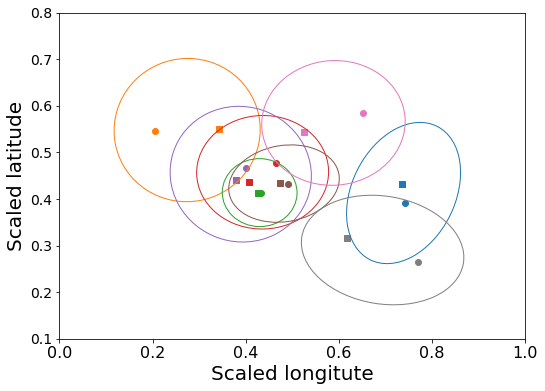

In [52]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111,aspect='equal')
ax.set_xlim(0,1)
ax.set_ylim(0.1,0.8)
ax.scatter(np.mean(cluster0.x_begin),np.mean(cluster0.y_begin),c=cyc_colors[0])
ax.scatter(np.mean(cluster0.x_end),np.mean(cluster0.y_end),c=cyc_colors[0],marker='s')
ax.add_artist(get_ellipse(cluster0,cyc_colors[0]))
ax.scatter(np.mean(cluster1.x_begin),np.mean(cluster1.y_begin),c=cyc_colors[1])
ax.scatter(np.mean(cluster1.x_end),np.mean(cluster1.y_end),c=cyc_colors[1],marker='s')
ax.add_artist(get_ellipse(cluster1,cyc_colors[1]))
ax.scatter(np.mean(cluster2.x_begin),np.mean(cluster2.y_begin),c=cyc_colors[2])
ax.scatter(np.mean(cluster2.x_end),np.mean(cluster2.y_end),c=cyc_colors[2],marker='s')
ax.add_artist(get_ellipse(cluster2,cyc_colors[2]))
ax.scatter(np.mean(cluster3.x_begin),np.mean(cluster3.y_begin),c=cyc_colors[3])
ax.scatter(np.mean(cluster3.x_end),np.mean(cluster3.y_end),c=cyc_colors[3],marker='s')
ax.add_artist(get_ellipse(cluster3,cyc_colors[3]))
ax.scatter(np.mean(cluster4.x_begin),np.mean(cluster4.y_begin),c=cyc_colors[4])
ax.scatter(np.mean(cluster4.x_end),np.mean(cluster4.y_end),c=cyc_colors[4],marker='s')
ax.add_artist(get_ellipse(cluster4,cyc_colors[4]))
ax.scatter(np.mean(cluster5.x_begin),np.mean(cluster5.y_begin),c=cyc_colors[5])
ax.scatter(np.mean(cluster5.x_end),np.mean(cluster5.y_end),c=cyc_colors[5],marker='s')
ax.add_artist(get_ellipse(cluster5,cyc_colors[5]))
ax.scatter(np.mean(cluster6.x_begin),np.mean(cluster6.y_begin),c=cyc_colors[6])
ax.scatter(np.mean(cluster6.x_end),np.mean(cluster6.y_end),c=cyc_colors[6],marker='s')
ax.add_artist(get_ellipse(cluster6,cyc_colors[6]))
ax.scatter(np.mean(cluster7.x_begin),np.mean(cluster7.y_begin),c=cyc_colors[7])
ax.scatter(np.mean(cluster7.x_end),np.mean(cluster7.y_end),c=cyc_colors[7],marker='s')
ax.add_artist(get_ellipse(cluster7,cyc_colors[7]))
ax.set_xlabel("Scaled longitute",fontsize=20)
ax.set_ylabel("Scaled latitude",fontsize=20)
plt.show()

In [53]:
print("cluster0",cluster0.time_begin.mean(),cluster0.time_begin.std(),cluster0.time_end.mean(),cluster0.time_end.std())
print("cluster1",cluster1.time_begin.mean(),cluster1.time_begin.std(),cluster1.time_end.mean(),cluster1.time_end.std())
print("cluster2",cluster2.time_begin.mean(),cluster2.time_begin.std(),cluster2.time_end.mean(),cluster2.time_end.std())
print("cluster3",cluster3.time_begin.mean(),cluster3.time_begin.std(),cluster3.time_end.mean(),cluster3.time_end.std())
print("cluster4",cluster4.time_begin.mean(),cluster4.time_begin.std(),cluster4.time_end.mean(),cluster4.time_end.std())
print("cluster5",cluster5.time_begin.mean(),cluster5.time_begin.std(),cluster5.time_end.mean(),cluster5.time_end.std())
print("cluster6",cluster6.time_begin.mean(),cluster6.time_begin.std(),cluster6.time_end.mean(),cluster6.time_end.std())
print("cluster7",cluster7.time_begin.mean(),cluster7.time_begin.std(),cluster7.time_end.mean(),cluster7.time_end.std())

cluster0 0.7464041039299958 0.17006641364472538 0.8526279326244566 0.14849860179714222
cluster1 0.21620426477804158 0.18922832968947004 0.3467866369499807 0.19880404687481304
cluster2 0.014357944546886074 0.026981849896120524 0.08740432948546366 0.06265351281877589
cluster3 0.5755944049243917 0.09827157409562663 0.6921785135369373 0.09419428344072045
cluster4 0.8707994073736623 0.08569050162890166 0.9605171047709564 0.048727400754267944
cluster5 0.26974994151867004 0.09744087362600709 0.39667364781829 0.08334726429998349
cluster6 0.0699323044279979 0.14615968932714993 0.2872237237616515 0.2511242023050252
cluster7 0.13737065432748663 0.15828344454859367 0.303310104286367 0.16676394226620644


Text(0.5, 0, 'time begin')

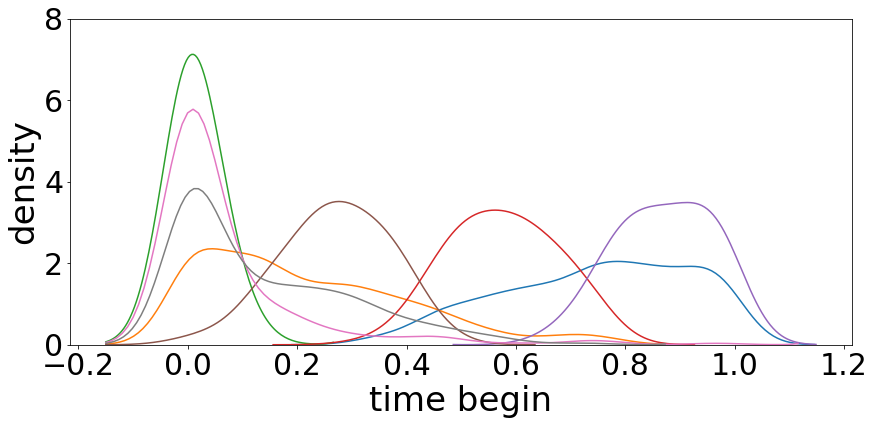

In [63]:
plt.figure(figsize=(14,6))
ax = sns.distplot(cluster0.time_begin,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster1.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster2.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster3.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster4.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster5.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster6.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster7.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax.set_ylim(0,8)
ax.set_ylabel("density",fontsize=34)
ax.set_xlabel("time begin",fontsize=34)

Text(0.5, 0, 'time end')

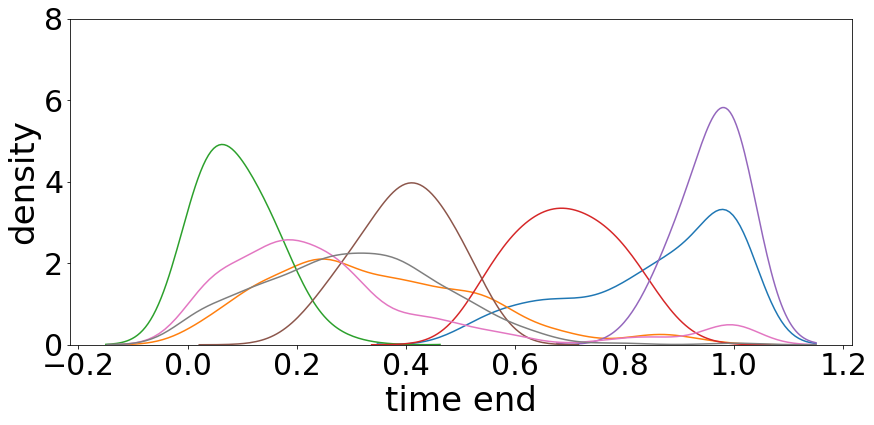

In [64]:
plt.figure(figsize=(14,6))
ax = sns.distplot(cluster0.time_end,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster1.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster2.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster3.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster4.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster5.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster6.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster7.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax.set_ylim(0,8)
ax.set_ylabel("density",fontsize=34)
ax.set_xlabel("time end",fontsize=34)

In [72]:
mds3dobj = MDS(n_components=3,dissimilarity='precomputed')

In [53]:
mds3dobj.fit(t1)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=3, n_init=4, n_jobs=1, random_state=None, verbose=0)

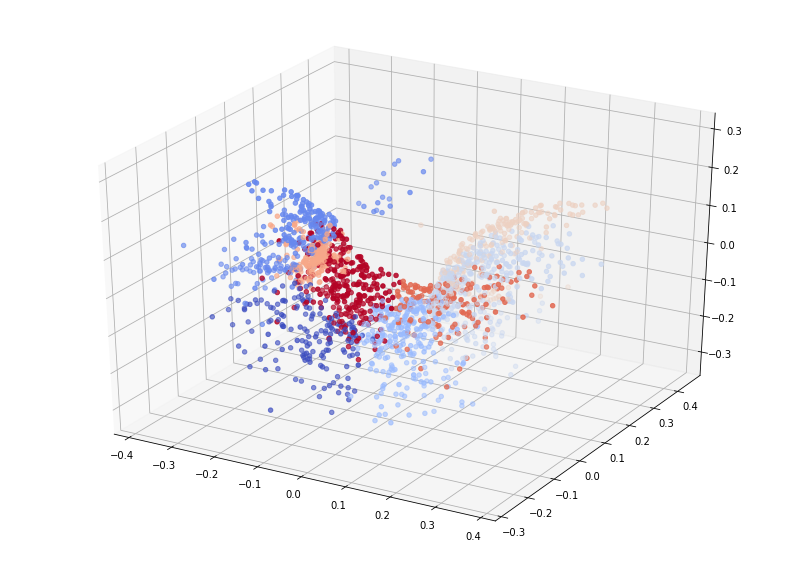

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds3dobj.embedding_[:,0],mds3dobj.embedding_[:,1],mds3dobj.embedding_[:,2],c=spcobj.labels_,cmap=plt.cm.coolwarm)
plt.show()